In [181]:
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import time as tm
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap

Load ground data observations

In [3]:
wpf_10m = pd.read_csv("wpf_10m.csv")

Drop entries that are <80% complete per day then aggregate

In [4]:
grouped = wpf_10m.groupby(['station_id', 'year', 'month', 'day'])

counts = grouped.size().reset_index(name='count')
counts['missing_percentage'] = 100 * (144 - counts['count']) / 144

valid_days = counts[counts['missing_percentage'] <= 20]
wpf_10m_filtered = pd.merge(wpf_10m, valid_days, on=['station_id', 'year', 'month', 'day'])
wpf_10m_filtered = wpf_10m_filtered.drop(columns=['count', 'missing_percentage'])

wpf_daily = wpf_10m_filtered.groupby(['station_id', 'year', 'month', 'day'], as_index=False).agg({'Rain': 'sum'})

In [142]:
wpf_daily.station_id.nunique()

767

##### 767 unique stations with /valid/ daily data

### Incorporate Climate Types

In [143]:
stations_coords = pd.read_csv("stations_coords.csv", index_col=0)

In [144]:
stations_coords

,station_id,lat,lon
0,980001,11.358100,120.7242
1,980003,10.658900,122.9658
2,980004,9.544000,125.8181
3,980005,8.590700,123.3422
4,980007,6.764600,125.3065
...,...,...,...
683,980984,10.162891,125.6682
684,980985,14.230609,121.0717
685,980987,7.370087,125.8621
686,980988,10.344330,123.6086


In [145]:
climate_gdf = gpd.read_file("ph_coronas_climate_type.shp")

In [146]:
climate_gdf

,CLIM_TYPE,geometry
0,1,"MULTIPOLYGON (((121.05841 13.72884, 121.05832 ..."
1,2,"MULTIPOLYGON (((125.42445 9.54577, 125.42445 9..."
2,3,"MULTIPOLYGON (((124.04107 6.7508, 124.04124 6...."
3,4,"MULTIPOLYGON (((124.50278 8.57778, 124.50361 8..."


In [147]:
stations_coords['geometry'] = stations_coords.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
stations_gdf = gpd.GeoDataFrame(stations_coords, geometry='geometry')

stations_gdf = stations_gdf.set_crs(climate_gdf.crs)
stations_with_climate = gpd.sjoin(stations_gdf, climate_gdf, how='left', predicate='within')
stations_with_climate = stations_with_climate.drop(columns=['geometry', 'index_right'])

In [148]:
stations_with_climate[stations_with_climate["CLIM_TYPE"].isna()]

,station_id,lat,lon,CLIM_TYPE
27,980041,14.090100,121.0073,NaN
168,980301,14.088600,121.0072,NaN
300,980485,10.157987,125.0039,NaN
559,980816,14.489100,121.0623,NaN


In [149]:
coordinate_to_clim_type = {
    (121.0072, 14.0886): 1,
    (121.0073, 14.0901): 1,
    (121.0623, 14.4891): 1,
    (125.0039, 10.157987): 4
}

def update_clim_type(row):
    if pd.isna(row['CLIM_TYPE']):
        coord = (row['lon'], row['lat'])
        return coordinate_to_clim_type.get(coord, np.nan)  
    return row['CLIM_TYPE']

# Apply the function to the DataFrame
stations_with_climate['CLIM_TYPE'] = stations_with_climate.apply(update_clim_type, axis=1)

Include climate type for wpf_daily

In [150]:
wpf_daily = pd.merge(wpf_daily, stations_with_climate[['station_id', 'CLIM_TYPE']], on='station_id', how='left')

In [151]:
wpf_daily

,station_id,year,month,day,Rain,CLIM_TYPE
0,980001,2013,2,15,0.0,1.0
1,980001,2013,2,16,0.0,1.0
2,980001,2013,2,21,0.0,1.0
3,980001,2013,2,22,4.0,1.0
4,980001,2013,2,23,0.0,1.0
...,...,...,...,...,...,...
757865,980989,2018,8,19,10.6,1.0
757866,980989,2018,8,20,2.2,1.0
757867,980989,2018,8,21,0.0,1.0
757868,980989,2018,8,22,0.0,1.0


688 unique stations and 6 years

In [152]:
wpf_daily = wpf_daily.dropna(subset=['CLIM_TYPE'])
print(wpf_daily.station_id.nunique())
print(wpf_daily.year.nunique())

688
6


### Data Cleaning 

#### Yearly completeness for wpf_daily

In [58]:
days_in_year = wpf_daily.groupby(['year']).apply(lambda x: 366 if (x['year'].iloc[0] % 4 == 0 and (x['year'].iloc[0] % 100 != 0 or x['year'].iloc[0] % 400 == 0)) else 365).reset_index(name='expected_days')

counts = wpf_daily.groupby(['station_id', 'year']).size().reset_index(name='days_with_data')
counts = pd.merge(counts, days_in_year, on='year')
counts['completeness'] = counts['days_with_data'] / counts['expected_days']

stations_to_remove = counts[counts['completeness'] < 0.8]['station_id'].unique()

wpf_daily = wpf_daily[~wpf_daily['station_id'].isin(stations_to_remove)]

In [59]:
wpf_daily

,station_id,year,month,day,Rain,CLIM_TYPE
87574,980088,2015,1,2,0.00,3.0
87575,980088,2015,1,3,0.00,3.0
87576,980088,2015,1,4,0.00,3.0
87577,980088,2015,1,5,1.29,3.0
87578,980088,2015,1,6,5.42,3.0
...,...,...,...,...,...,...
757568,980987,2018,12,27,0.00,4.0
757569,980987,2018,12,28,0.00,4.0
757570,980987,2018,12,29,0.00,4.0
757571,980987,2018,12,30,7.20,4.0


82 stations left with 4 years

In [213]:
print(wpf_daily.station_id.nunique())
print(wpf_daily.year.nunique())

82
4


In [214]:
print(wpf_daily.groupby('CLIM_TYPE')['station_id'].nunique())

CLIM_TYPE
1.0    20
2.0    11
3.0    33
4.0    18
Name: station_id, dtype: int64


#### Plotting

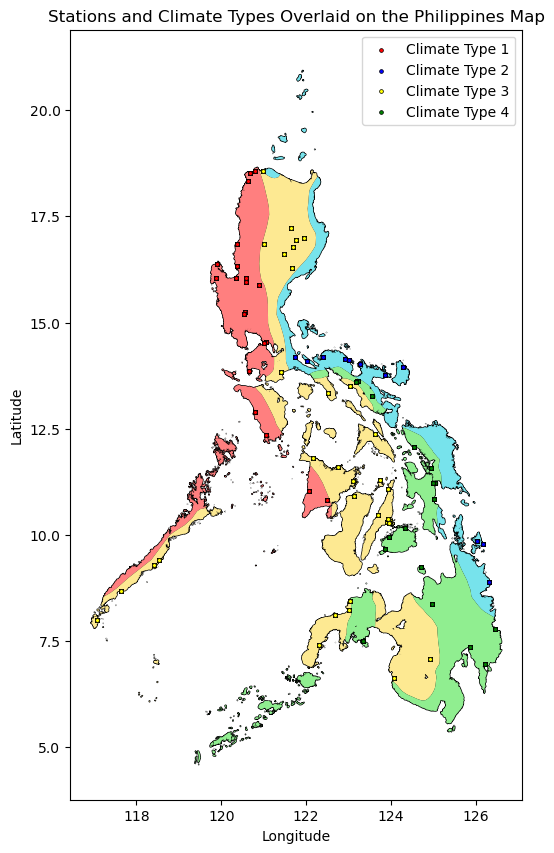

In [60]:
merged_stations = wpf_daily.merge(stations_coords, on="station_id")

geometry = [Point(xy) for xy in zip(merged_stations['lon'], merged_stations['lat'])]
stations_gdf = gpd.GeoDataFrame(merged_stations, geometry=geometry)

fig, ax = plt.subplots(figsize=(10, 10))
climate_colors = {
    1: '#FF7F7F',  # light red
    2: '#77E3EC',  # light blue
    3: '#FDE992',  # light yellow
    4: '#90EE90'   # light green
}

climate_gdf.plot(ax=ax, color='lightblue', edgecolor='black')

for clim_type, color in climate_colors.items():
    climate_gdf[climate_gdf['CLIM_TYPE'] == clim_type].plot(ax=ax, color=color)

station_colors = {
    1: 'red',
    2: 'blue',
    3: 'yellow',
    4: 'green'
}

for clim_type, color in station_colors.items():
    subset = stations_gdf[stations_gdf['CLIM_TYPE'] == clim_type]
    subset.plot(ax=ax, marker='o', color=color, markersize=7.5, edgecolor='black', linewidth=0.5, label=f'Climate Type {clim_type}')

ax.set_title("Stations and Climate Types Overlaid on the Philippines Map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

### Checking valid stations for monthly aggregates

Count how many days have missing data

In [61]:
def count_missing_data(df):
    grouped = df.groupby(['station_id', 'year', 'month'])
    
    result = []
    
    for (station_id, year, month), group in grouped:
        # Total days in the month for the specific year
        days_in_month = pd.Timestamp(year=year, month=month, day=1).days_in_month
        missing_days = days_in_month - group['day'].nunique() + group['Rain'].isna().sum()
        
        result.append({
            'station_id': station_id,
            'year': year,
            'month': month,
            'missing_days': missing_days
        })
    
    return pd.DataFrame(result)\
    
missing_data_count = count_missing_data(wpf_daily)

# Identify and drop rows with 5 or more missing days
rows_to_drop = missing_data_count[missing_data_count['missing_days'] >= 5]

In [62]:
# Drop this data before doing monthly aggregates for analysis
rows_to_drop

,station_id,year,month,missing_days
41,980183,2016,6,22
46,980183,2016,11,28
89,980369,2016,6,15
142,980371,2016,11,22
208,980387,2016,5,24
...,...,...,...,...
3134,980952,2018,6,5
3141,980953,2017,2,14
3157,980953,2018,6,5
3164,980955,2017,2,17


'rows_to_drop' now contains the station-year-month to drop for aggregates|

# MSWEP Data

### data prep

In [63]:
#Loading DAILY MSWEP Data
mswep_daily = pd.read_csv("mswep_daily.csv", index_col=0)

In [64]:
mswep_daily

,station_id,CLIM_TYPE,year,month,day,mswep_daily_Pr
0,980088.0,3.0,2013,1,1,0.5625
1,980088.0,3.0,2013,1,2,1.1250
2,980088.0,3.0,2013,1,3,2.8125
3,980088.0,3.0,2013,1,4,10.9375
4,980088.0,3.0,2013,1,5,2.8125
...,...,...,...,...,...,...
179739,980987.0,4.0,2018,12,28,0.0000
179740,980987.0,4.0,2018,12,29,0.7500
179741,980987.0,4.0,2018,12,30,4.6250
179742,980987.0,4.0,2018,12,31,1.7500


In [65]:
# Merging DAILY wpf and mswep data

wpf_mswep_daily = pd.merge(
    wpf_daily,
    mswep_daily,
    on=['station_id', 'year', 'month', 'day', 'CLIM_TYPE'], 
    how='inner'
)

In [66]:
wpf_mswep_daily

,station_id,year,month,day,Rain,CLIM_TYPE,mswep_daily_Pr
0,980088,2015,1,2,0.00,3.0,0.6250
1,980088,2015,1,3,0.00,3.0,0.5625
2,980088,2015,1,4,0.00,3.0,0.2500
3,980088,2015,1,5,1.29,3.0,0.9375
4,980088,2015,1,6,5.42,3.0,1.6875
...,...,...,...,...,...,...,...
93886,980987,2018,12,27,0.00,4.0,0.0000
93887,980987,2018,12,28,0.00,4.0,0.0000
93888,980987,2018,12,29,0.00,4.0,0.7500
93889,980987,2018,12,30,7.20,4.0,4.6250


In [67]:
wpf_mswep_daily = wpf_mswep_daily.rename(columns={'Rain': 'wpf_daily_Pr'})

In [68]:
# Categorizing precipitation
def categorize_precipitation(pr):
    if np.isnan(pr):
        return np.nan
    elif pr == 0:
        return 'No'
    elif 0 < pr < 1:
        return 'Dry'
    elif 1 <= pr < 10:
        return 'LightMod'
    elif 10 <= pr <= 20:
        return 'Heavy'
    else:  # pr > 20
        return 'VeryH'

# Apply to both wpf_daily_Pr and mswep_daily_Pr
wpf_mswep_daily['wpf_categ'] = wpf_mswep_daily['wpf_daily_Pr'].apply(categorize_precipitation)
wpf_mswep_daily['mswep_categ'] = wpf_mswep_daily['mswep_daily_Pr'].apply(categorize_precipitation)

In [69]:
wpf_mswep_daily

,station_id,year,month,day,wpf_daily_Pr,CLIM_TYPE,mswep_daily_Pr,wpf_categ,mswep_categ
0,980088,2015,1,2,0.00,3.0,0.6250,No,Dry
1,980088,2015,1,3,0.00,3.0,0.5625,No,Dry
2,980088,2015,1,4,0.00,3.0,0.2500,No,Dry
3,980088,2015,1,5,1.29,3.0,0.9375,LightMod,Dry
4,980088,2015,1,6,5.42,3.0,1.6875,LightMod,LightMod
...,...,...,...,...,...,...,...,...,...
93886,980987,2018,12,27,0.00,4.0,0.0000,No,No
93887,980987,2018,12,28,0.00,4.0,0.0000,No,No
93888,980987,2018,12,29,0.00,4.0,0.7500,No,Dry
93889,980987,2018,12,30,7.20,4.0,4.6250,LightMod,LightMod


In [70]:
wpf_mswep_daily['Bias_mswep'] = (wpf_mswep_daily['mswep_daily_Pr'] - wpf_mswep_daily['wpf_daily_Pr'])

In [71]:
wpf_mswep_daily

,station_id,year,month,day,wpf_daily_Pr,CLIM_TYPE,mswep_daily_Pr,wpf_categ,mswep_categ,Bias_mswep
0,980088,2015,1,2,0.00,3.0,0.6250,No,Dry,0.6250
1,980088,2015,1,3,0.00,3.0,0.5625,No,Dry,0.5625
2,980088,2015,1,4,0.00,3.0,0.2500,No,Dry,0.2500
3,980088,2015,1,5,1.29,3.0,0.9375,LightMod,Dry,-0.3525
4,980088,2015,1,6,5.42,3.0,1.6875,LightMod,LightMod,-3.7325
...,...,...,...,...,...,...,...,...,...,...
93886,980987,2018,12,27,0.00,4.0,0.0000,No,No,0.0000
93887,980987,2018,12,28,0.00,4.0,0.0000,No,No,0.0000
93888,980987,2018,12,29,0.00,4.0,0.7500,No,Dry,0.7500
93889,980987,2018,12,30,7.20,4.0,4.6250,LightMod,LightMod,-2.5750


In [72]:
#Monthly data for aggregates

# Merge wpf_mswep_daily with rows_to_drop on station_id, year, and month
merged = pd.merge(
    wpf_mswep_daily,
    rows_to_drop[['station_id', 'year', 'month']],
    on=['station_id', 'year', 'month'],
    how='left', 
    indicator=True  
)

wpf_mswep_daily_cleaned = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])

wpf_mswep_monthly = wpf_mswep_daily_cleaned.groupby(['station_id', 'year', 'month', 'CLIM_TYPE']).agg({
    'wpf_daily_Pr': 'sum',  # Summing the daily precipitation for each month
    'mswep_daily_Pr': 'sum'  # Summing the daily precipitation for each month
}).reset_index()

In [73]:
wpf_mswep_monthly

,station_id,year,month,CLIM_TYPE,wpf_daily_Pr,mswep_daily_Pr
0,980088,2015,1,3.0,198.71,145.0625
1,980088,2015,2,3.0,189.44,72.4375
2,980088,2015,3,3.0,193.19,84.0000
3,980088,2015,4,3.0,136.60,165.3125
4,980088,2015,5,3.0,57.00,203.3750
...,...,...,...,...,...,...
2954,980987,2018,6,4.0,139.20,114.0625
2955,980987,2018,7,4.0,113.60,109.0625
2956,980987,2018,10,4.0,135.00,147.0625
2957,980987,2018,11,4.0,131.20,122.3750


In [76]:
# Valid monthly data but for daily values

merged = wpf_mswep_daily.merge(rows_to_drop[['station_id', 'year', 'month']], on=['station_id', 'year', 'month'], how='left', indicator=True)
wpf_mswep_daily_for_month = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
wpf_mswep_daily_for_month = wpf_mswep_daily_for_month[wpf_mswep_daily.columns]

In [77]:
wpf_mswep_daily_for_month

,station_id,year,month,day,wpf_daily_Pr,CLIM_TYPE,mswep_daily_Pr,wpf_categ,mswep_categ,Bias_mswep
0,980088,2015,1,2,0.00,3.0,0.6250,No,Dry,0.6250
1,980088,2015,1,3,0.00,3.0,0.5625,No,Dry,0.5625
2,980088,2015,1,4,0.00,3.0,0.2500,No,Dry,0.2500
3,980088,2015,1,5,1.29,3.0,0.9375,LightMod,Dry,-0.3525
4,980088,2015,1,6,5.42,3.0,1.6875,LightMod,LightMod,-3.7325
...,...,...,...,...,...,...,...,...,...,...
93886,980987,2018,12,27,0.00,4.0,0.0000,No,No,0.0000
93887,980987,2018,12,28,0.00,4.0,0.0000,No,No,0.0000
93888,980987,2018,12,29,0.00,4.0,0.7500,No,Dry,0.7500
93889,980987,2018,12,30,7.20,4.0,4.6250,LightMod,LightMod,-2.5750


In [81]:
# Group by year, month, and category, and count the occurrences
wpf_categ_counts = wpf_mswep_daily_for_month.groupby(['year', 'month', 'wpf_categ']).size().unstack(fill_value=0)
mswep_categ_counts = wpf_mswep_daily_for_month.groupby(['year', 'month', 'mswep_categ']).size().unstack(fill_value=0)

# Combine the two counts into a single DataFrame
category_counts = pd.concat([wpf_categ_counts, mswep_categ_counts], axis=1, keys=['WPF', 'MSWEP'])

### Comparison

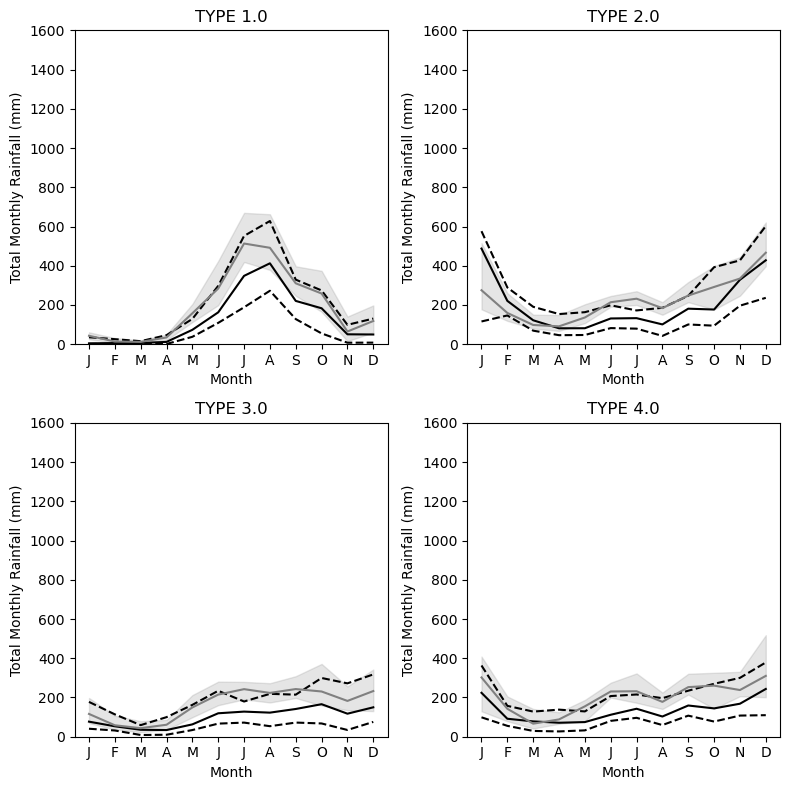

In [78]:
#Monthly Statistics Data

# Statistics for WPF and MSWEP data
wpf_stats = wpf_mswep_monthly.groupby(['CLIM_TYPE', 'month'])['wpf_daily_Pr'].agg(['median'])
wpf_stats['P25'] = wpf_mswep_monthly.groupby(['CLIM_TYPE', 'month'])['wpf_daily_Pr'].quantile(0.25)
wpf_stats['P75'] = wpf_mswep_monthly.groupby(['CLIM_TYPE', 'month'])['wpf_daily_Pr'].quantile(0.75)

mswep_stats = wpf_mswep_monthly.groupby(['CLIM_TYPE', 'month'])['mswep_daily_Pr'].agg(['median'])
mswep_stats['P25'] = wpf_mswep_monthly.groupby(['CLIM_TYPE', 'month'])['mswep_daily_Pr'].quantile(0.25)
mswep_stats['P75'] = wpf_mswep_monthly.groupby(['CLIM_TYPE', 'month'])['mswep_daily_Pr'].quantile(0.75)

max_y = 1600

plt.figure(figsize=(8, 8))
positions = {1: 1, 2: 2, 3: 3, 4: 4}

for clim_type in wpf_stats.index.get_level_values(0).unique():
    plt.subplot(2, 2, positions[clim_type])
    
    wpf_subset = wpf_stats.loc[clim_type]
    mswep_subset = mswep_stats.loc[clim_type]
    
    # Plot WPF data
    plt.plot(wpf_subset.index, wpf_subset['median'], label=f'WPF TYPE {clim_type}', color='black')
    plt.plot(wpf_subset.index, wpf_subset['P25'], linestyle='--', color='black')
    plt.plot(wpf_subset.index, wpf_subset['P75'], linestyle='--', color='black')
    
    # Plot MSWEP data
    plt.plot(mswep_subset.index, mswep_subset['median'], label=f'MSWEP TYPE {clim_type}', color='gray')
    plt.fill_between(mswep_subset.index, mswep_subset['P25'], mswep_subset['P75'], color='gray', alpha=0.2)
    
    plt.xlabel('Month')
    plt.ylabel('Total Monthly Rainfall (mm)')
    plt.xticks(range(1, 13), ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    plt.title(f'TYPE {clim_type}')
    
    # Set consistent y-limits
    plt.ylim(0, max_y)

plt.tight_layout()
plt.show()

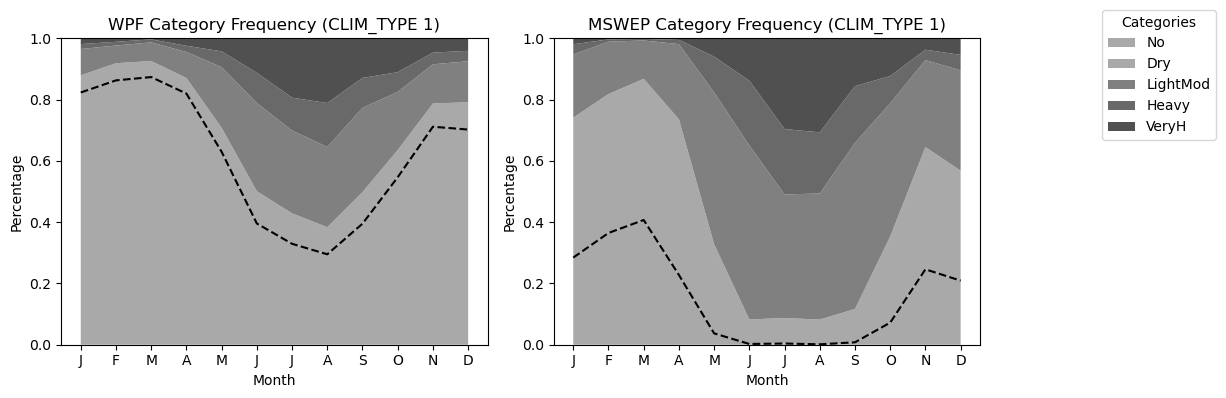

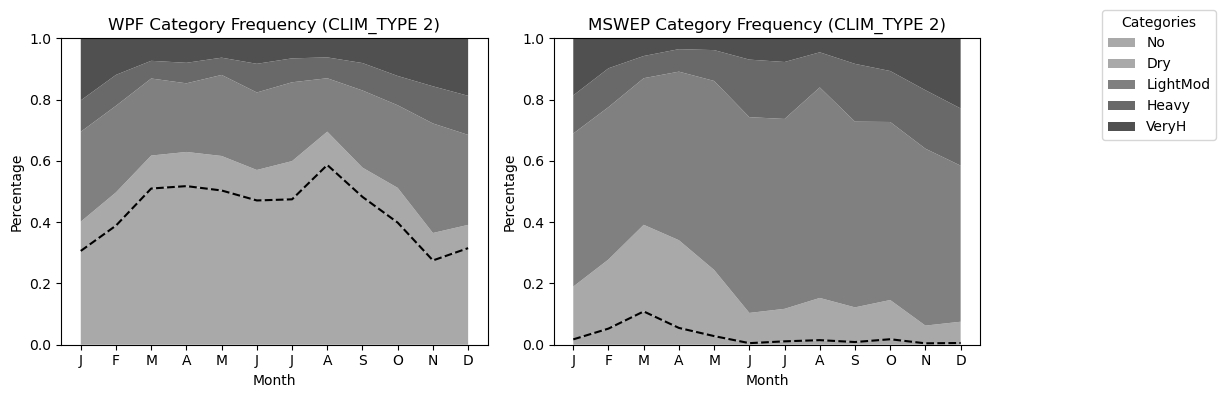

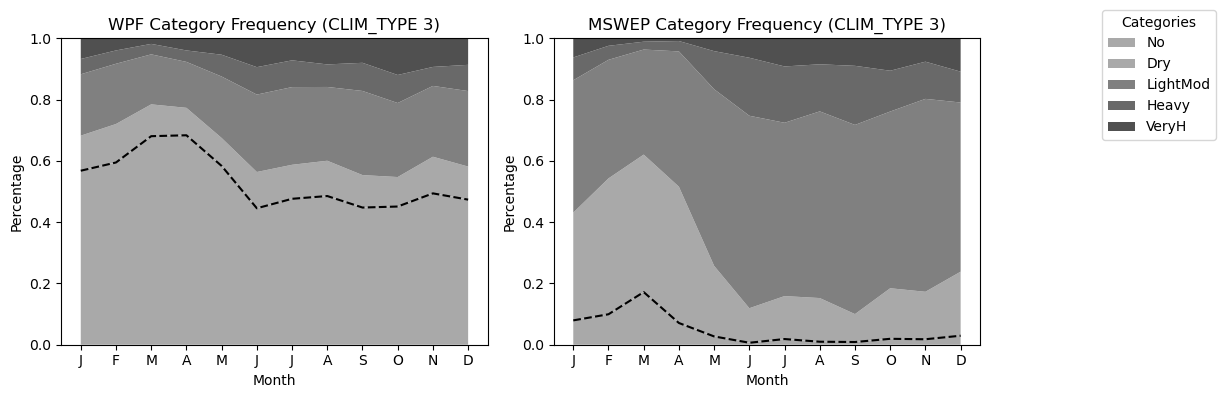

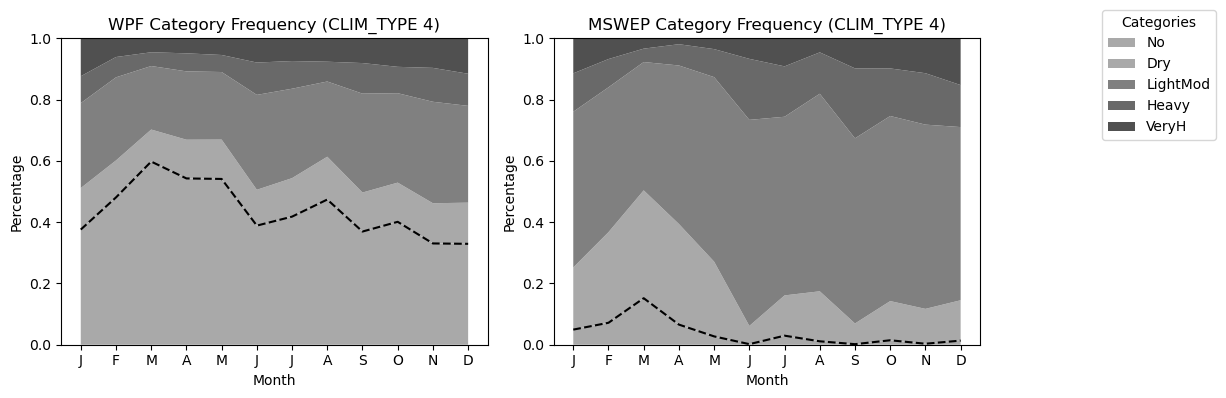

In [79]:
#Rainfall Category Frequency

months = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
category_order = ['No', 'Dry', 'LightMod', 'Heavy', 'VeryH']
colors = ['#A9A9A9', '#A9A9A9', '#808080', '#696969', '#505050']
clim_type_order = [1, 2, 3, 4]

for clim_type in clim_type_order:
    
    filtered_data = wpf_mswep_daily_for_month[wpf_mswep_daily_for_month['CLIM_TYPE'] == clim_type]
    
    wpf_categ_monthly = filtered_data.groupby('month')['wpf_categ'].value_counts(normalize=True).unstack(fill_value=0)
    mswep_categ_monthly = filtered_data.groupby('month')['mswep_categ'].value_counts(normalize=True).unstack(fill_value=0)
    
    wpf_categ_monthly = wpf_categ_monthly[category_order]
    mswep_categ_monthly = mswep_categ_monthly[category_order]
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    axes[0].stackplot(wpf_categ_monthly.index, wpf_categ_monthly.T, labels=category_order, colors=colors)
    axes[0].plot(wpf_categ_monthly.index, wpf_categ_monthly['No'], linestyle='--', color='black')
    axes[0].set_ylim(0, 1)
    axes[0].set_xticks(range(1, 13))
    axes[0].set_xticklabels(months)
    axes[0].set_title(f'WPF Category Frequency (CLIM_TYPE {clim_type})')
    axes[0].set_ylabel('Percentage')
    axes[0].set_xlabel('Month')
    
    axes[1].stackplot(mswep_categ_monthly.index, mswep_categ_monthly.T, labels=category_order, colors=colors)
    axes[1].plot(mswep_categ_monthly.index, mswep_categ_monthly['No'], linestyle='--', color='black')
    axes[1].set_ylim(0, 1)
    axes[1].set_xticks(range(1, 13))
    axes[1].set_xticklabels(months)
    axes[1].set_title(f'MSWEP Category Frequency (CLIM_TYPE {clim_type})')
    axes[1].set_ylabel('Percentage')
    axes[1].set_xlabel('Month')
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Categories', bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

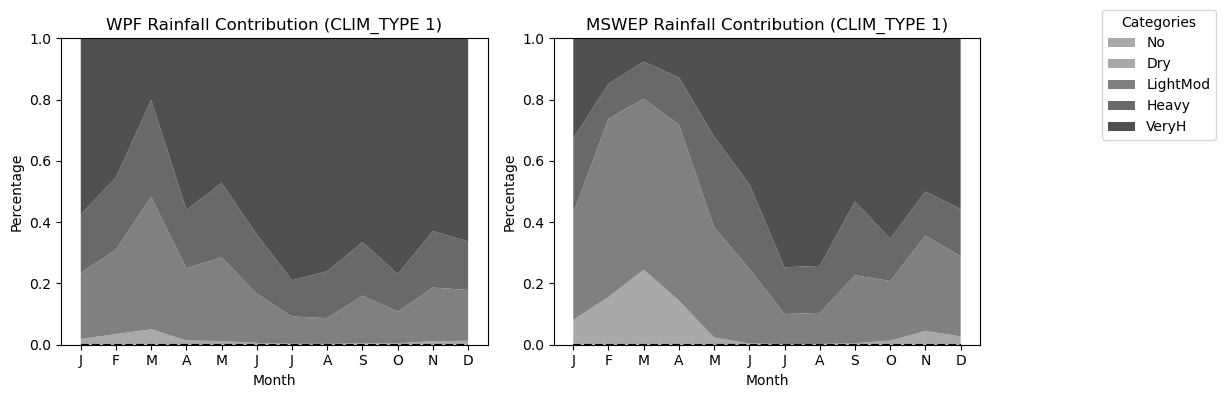

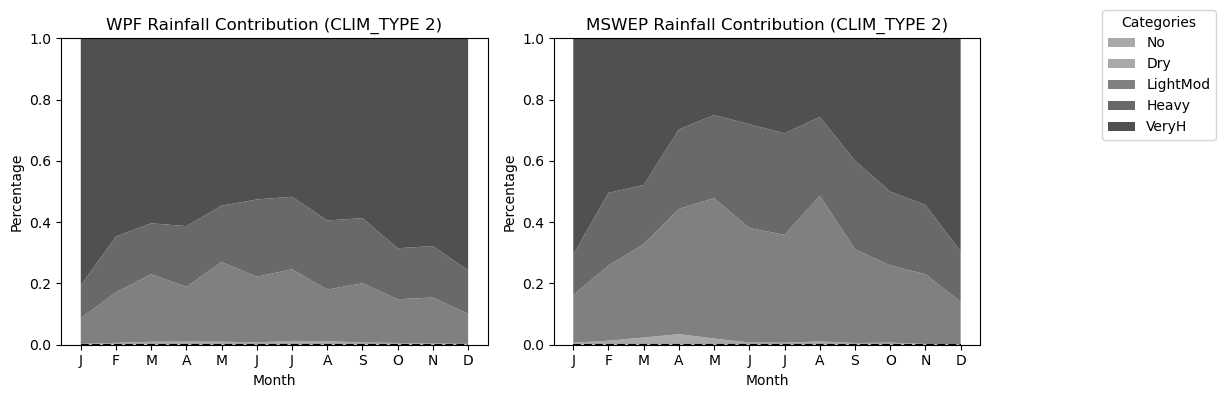

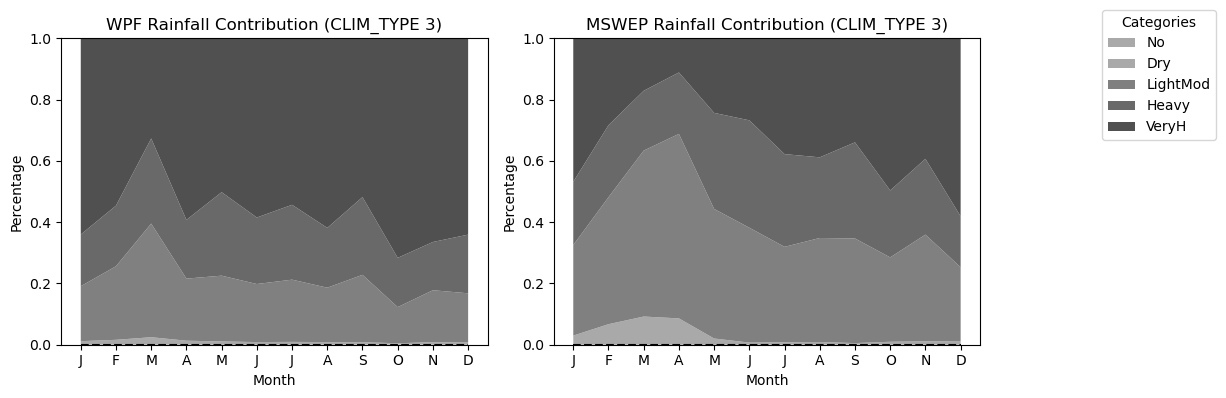

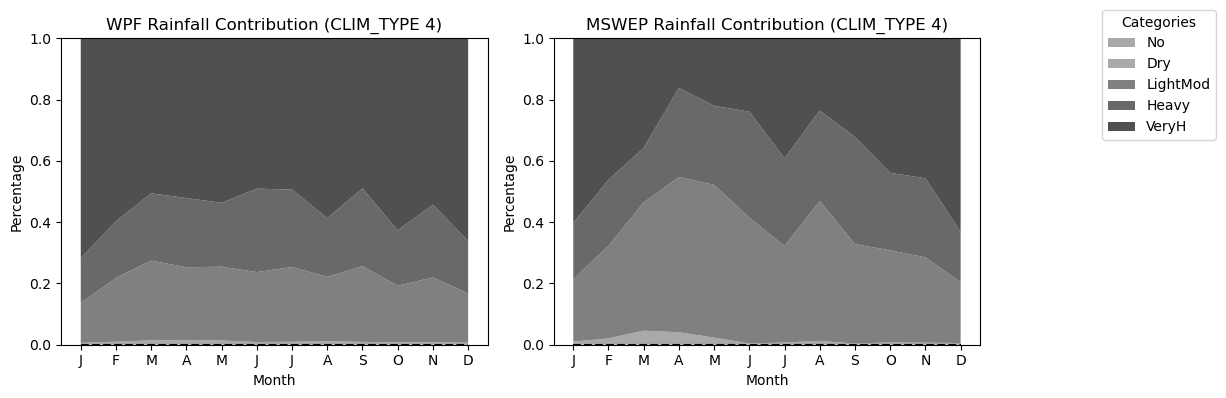

In [80]:
#Rainfall Category Contirubtion
clim_type_order = [1, 2, 3, 4]

for clim_type in clim_type_order:
    filtered_data = wpf_mswep_daily_for_month[wpf_mswep_daily_for_month['CLIM_TYPE'] == clim_type]

    wpf_rainfall = filtered_data.groupby(['year', 'month', 'wpf_categ'])['wpf_daily_Pr'].sum().unstack(fill_value=0)
    mswep_rainfall = filtered_data.groupby(['year', 'month', 'mswep_categ'])['mswep_daily_Pr'].sum().unstack(fill_value=0)

    wpf_rainfall_monthly = wpf_rainfall.groupby('month').sum()
    mswep_rainfall_monthly = mswep_rainfall.groupby('month').sum()

    wpf_rainfall_percent = wpf_rainfall_monthly.div(wpf_rainfall_monthly.sum(axis=1), axis=0)
    mswep_rainfall_percent = mswep_rainfall_monthly.div(mswep_rainfall_monthly.sum(axis=1), axis=0)

    wpf_rainfall_percent = wpf_rainfall_percent[category_order]
    mswep_rainfall_percent = mswep_rainfall_percent[category_order]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].stackplot(wpf_rainfall_percent.index, wpf_rainfall_percent.T, labels=category_order, colors=colors)
    axes[0].plot(wpf_rainfall_percent.index, wpf_rainfall_percent['No'], linestyle='--', color='black')
    axes[0].set_ylim(0, 1)
    axes[0].set_xticks(range(1, 13))
    axes[0].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    axes[0].set_title(f'WPF Rainfall Contribution (CLIM_TYPE {clim_type})')
    axes[0].set_ylabel('Percentage')
    axes[0].set_xlabel('Month')

    axes[1].stackplot(mswep_rainfall_percent.index, mswep_rainfall_percent.T, labels=category_order, colors=colors)
    axes[1].plot(mswep_rainfall_percent.index, mswep_rainfall_percent['No'], linestyle='--', color='black')
    axes[1].set_ylim(0, 1)
    axes[1].set_xticks(range(1, 13))
    axes[1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    axes[1].set_title(f'MSWEP Rainfall Contribution (CLIM_TYPE {clim_type})')
    axes[1].set_ylabel('Percentage')
    axes[1].set_xlabel('Month')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Categories', bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

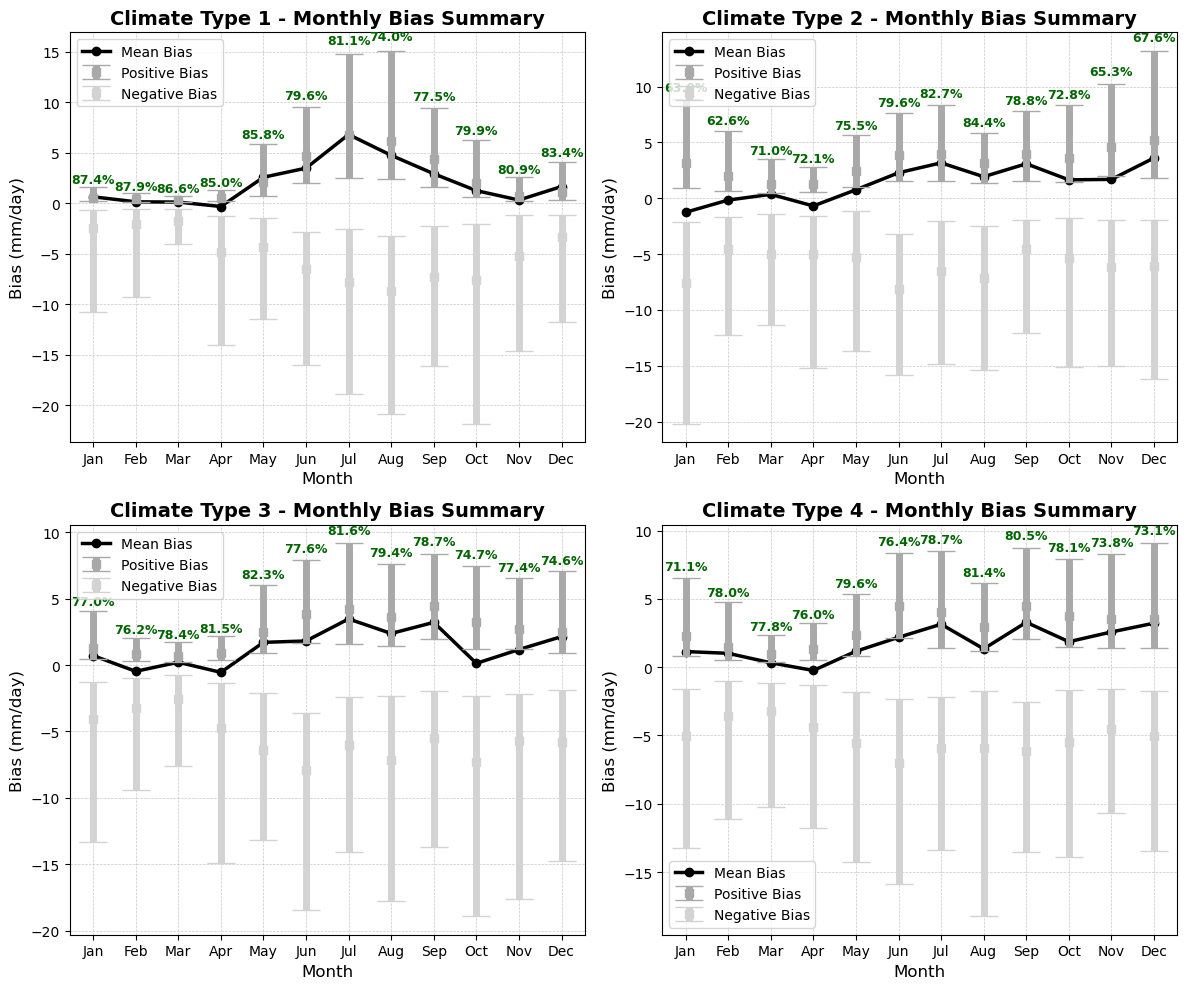

In [82]:
# Montlhy biases

def prepare_bias_data(df, clim_type):
    data = df[df['CLIM_TYPE'] == clim_type].copy()

    # Handle infinite and NaN values
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna(subset=['Bias_mswep'])

    months = range(1, 13)
    mean_bias = []
    pos_median = []
    pos_p25 = []
    pos_p75 = []
    neg_median = []
    neg_p25 = []
    neg_p75 = []
    pos_freq = []
    neg_freq = []
    dominant_bias = []

    for month in months:
        month_data = data[data['month'] == month]
        biases = month_data['Bias_mswep']

        # Mean bias
        mean = biases.mean()
        mean_bias.append(mean)

        # Positive biases
        pos_biases = biases[biases > 0]
        pos_median.append(pos_biases.median())
        pos_p25.append(pos_biases.quantile(0.25))
        pos_p75.append(pos_biases.quantile(0.75))
        pos_count = pos_biases.count()

        # Negative biases
        neg_biases = biases[biases < 0]
        neg_median.append(neg_biases.median())
        neg_p25.append(neg_biases.quantile(0.25))
        neg_p75.append(neg_biases.quantile(0.75))
        neg_count = neg_biases.count()

        # Frequencies
        total_count = pos_count + neg_count
        if total_count == 0:
            pos_frequency = 0
            neg_frequency = 0
            dominant = 'No Data'
        else:
            pos_frequency = (pos_count / total_count) * 100
            neg_frequency = (neg_count / total_count) * 100
            dominant = 'Positive' if pos_frequency >= neg_frequency else 'Negative'

        pos_freq.append(pos_frequency)
        neg_freq.append(neg_frequency)
        dominant_bias.append(dominant)

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Month': months,
        'Mean_Bias': mean_bias,
        'Pos_Median': pos_median,
        'Pos_P25': pos_p25,
        'Pos_P75': pos_p75,
        'Neg_Median': neg_median,
        'Neg_P25': neg_p25,
        'Neg_P75': neg_p75,
        'Pos_Frequency': pos_freq,
        'Neg_Frequency': neg_freq,
        'Dominant_Bias': dominant_bias
    })

    return summary_df

# Plotting function
def plot_bias_summary(summary_df, ax, clim_type):
    months_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Plot mean bias
    ax.plot(summary_df['Month'], summary_df['Mean_Bias'], color='black', linewidth=2.5, label='Mean Bias', marker='o')

    # Plot positive bias bars
    ax.errorbar(
        summary_df['Month'],
        summary_df['Pos_Median'],
        yerr=[summary_df['Pos_Median'] - summary_df['Pos_P25'], summary_df['Pos_P75'] - summary_df['Pos_Median']],
        fmt='s',
        color='darkgray',
        ecolor='darkgray',
        elinewidth=5,
        capsize=10,
        label='Positive Bias'
    )

    # Plot negative bias bars
    ax.errorbar(
        summary_df['Month'],
        summary_df['Neg_Median'],
        yerr=[summary_df['Neg_Median'] - summary_df['Neg_P25'], summary_df['Neg_P75'] - summary_df['Neg_Median']],
        fmt='s',
        color='lightgray',
        ecolor='lightgray',
        elinewidth=5,
        capsize=10,
        label='Negative Bias'
    )

    # Add frequency annotations
    for idx, row in summary_df.iterrows():
        month = row['Month']
        if row['Dominant_Bias'] == 'Positive':
            ax.text(
                month,
                row['Pos_P75'] + 0.05 * abs(row['Pos_P75']),
                f"{row['Pos_Frequency']:.1f}%",
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold',
                color='darkgreen'
            )
        elif row['Dominant_Bias'] == 'Negative':
            ax.text(
                month,
                row['Neg_P25'] - 0.05 * abs(row['Neg_P25']),
                f"{row['Neg_Frequency']:.1f}%",
                ha='center',
                va='top',
                fontsize=9,
                fontweight='bold',
                color='darkred'
            )
        else:
            ax.text(
                month,
                0,
                "No Data",
                ha='center',
                va='center',
                fontsize=9,
                fontweight='bold',
                color='gray'
            )

    # Customize the plot
    ax.set_xticks(summary_df['Month'])
    ax.set_xticklabels(months_labels)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Bias (mm/day)', fontsize=12)
    ax.set_title(f'Climate Type {clim_type} - Monthly Bias Summary', fontsize=14, fontweight='bold')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend()

# Main plotting routine for all climate types
def plot_all_climate_biases(df):
    climate_types = [1, 2, 3, 4]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    for clim_type, ax in zip(climate_types, axes.flatten()):
        summary_df = prepare_bias_data(df, clim_type)
        plot_bias_summary(summary_df, ax, clim_type)

    plt.tight_layout()
    plt.show()

plot_all_climate_biases(wpf_mswep_daily_for_month)

In [87]:
#Statistical Metrics

df_daily = wpf_mswep_daily
df_monthly = wpf_mswep_monthly

def custom_r2(observed, predicted):
    # Calculate means
    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)
    
    # Calculate standard deviations
    std_observed = np.std(observed, ddof=1)  # ddof=1 for sample standard deviation
    std_predicted = np.std(predicted, ddof=1)
    
    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = (len(observed) - 1) * std_observed * std_predicted
    r2 = (numerator / denominator) ** 2
    
    return r2

# Function to remove NaN and inf values and compute statistics
def compute_stats(wpf_values, mswep_values):
    # Create a boolean mask to filter out NaN and inf values
    mask = ~np.isnan(wpf_values) & ~np.isnan(mswep_values) & \
           np.isfinite(wpf_values) & np.isfinite(mswep_values)
    
    wpf_values_filtered = wpf_values[mask]
    mswep_values_filtered = mswep_values[mask]
    
    rmse = np.sqrt(mean_squared_error(wpf_values_filtered, mswep_values_filtered))
    mae = mean_absolute_error(wpf_values_filtered, mswep_values_filtered)
    r2 = custom_r2(wpf_values_filtered, mswep_values_filtered)
    ks_statistic, ks_p_value = stats.ks_2samp(wpf_values_filtered, mswep_values_filtered)
    
    return rmse, mae, r2, ks_statistic, ks_p_value

results_df = pd.DataFrame(columns=['Climate Type', 'Aggregation', 'RMSE', 'MAE', 'R2', 'KS_Statistic', 'KS_P_Value'])

# Iterate over each climate type
for clim_type in sorted(df_daily['CLIM_TYPE'].unique()):
    df_clim_daily = df_daily[df_daily['CLIM_TYPE'] == clim_type]
    df_clim_monthly = df_monthly[df_monthly['CLIM_TYPE'] == clim_type]

    # 1. Daily Statistics
    daily_stats = compute_stats(df_clim_daily['wpf_daily_Pr'], df_clim_daily['mswep_daily_Pr'])
    results_df = pd.concat([results_df, pd.DataFrame({
        'Climate Type': clim_type,
        'Aggregation': 'Daily',
        'RMSE': daily_stats[0],
        'MAE': daily_stats[1],
        'R2': daily_stats[2],
        'KS_Statistic': daily_stats[3],
        'KS_P_Value': daily_stats[4]
    }, index=[0])], ignore_index=True)

    # 2. Monthly Statistics
    monthly_stats = compute_stats(df_clim_monthly['wpf_daily_Pr'], df_clim_monthly['mswep_daily_Pr'])
    results_df = pd.concat([results_df, pd.DataFrame({
        'Climate Type': clim_type,
        'Aggregation': 'Monthly',
        'RMSE': monthly_stats[0],
        'MAE': monthly_stats[1],
        'R2': monthly_stats[2],
        'KS_Statistic': monthly_stats[3],
        'KS_P_Value': monthly_stats[4]
    }, index=[0])], ignore_index=True)

    # 3. Seasonal Statistics
    df_clim_monthly['season'] = np.where(df_clim_monthly['month'].isin([12, 1, 2]), 'DJF',
                                         np.where(df_clim_monthly['month'].isin([3, 4, 5]), 'MAM',
                                         np.where(df_clim_monthly['month'].isin([6, 7, 8]), 'JJA',
                                         'SON')))

    seasonal_df = df_clim_monthly.groupby(['station_id', 'year', 'season']).agg({
        'wpf_daily_Pr': 'sum',
        'mswep_daily_Pr': 'sum'
    }).reset_index()

    seasonal_stats = compute_stats(seasonal_df['wpf_daily_Pr'], seasonal_df['mswep_daily_Pr'])
    results_df = pd.concat([results_df, pd.DataFrame({
        'Climate Type': clim_type,
        'Aggregation': 'Seasonal',
        'RMSE': seasonal_stats[0],
        'MAE': seasonal_stats[1],
        'R2': seasonal_stats[2],
        'KS_Statistic': seasonal_stats[3],
        'KS_P_Value': seasonal_stats[4]
    }, index=[0])], ignore_index=True)

# The final results DataFrame
results_df

C:\Users\neris\AppData\Local\Temp\ipykernel_40900\2740159134.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({
C:\Users\neris\AppData\Local\Temp\ipykernel_40900\2740159134.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim_monthly['season'] = np.where(df_clim_monthly['month'].isin([12, 1, 2]), 'DJF',
C:\Users\neris\AppData\Local\Temp\ipykernel_40900\2740159134.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,Climate Type,Aggregation,RMSE,MAE,R2,KS_Statistic,KS_P_Value
0,1.0,Daily,13.536158,5.885789,0.417340,0.461244,0.000000e+00
1,1.0,Monthly,178.157622,112.867189,0.565224,0.210976,2.187548e-16
2,1.0,Seasonal,431.050968,280.724348,0.588977,0.240803,5.125863e-08
3,2.0,Daily,15.426754,7.535452,0.313863,0.417557,0.000000e+00
4,2.0,Monthly,207.489331,146.259706,0.170327,0.235566,6.019995e-11
5,2.0,Seasonal,521.186971,359.460435,0.139280,0.316129,3.017813e-07
6,3.0,Daily,13.572471,6.344951,0.150840,0.487616,0.000000e+00
7,3.0,Monthly,175.941342,123.127124,0.106410,0.244860,1.471394e-28
8,3.0,Seasonal,438.202825,314.725371,0.099880,0.281250,8.862394e-14
9,4.0,Daily,13.118284,6.569199,0.256664,0.415677,0.000000e+00


In [147]:
df_clim_monthly

,station_id,year,month,CLIM_TYPE,wpf_daily_Pr,mswep_daily_Pr,season
117,980371,2015,1,4.0,238.6,216.8750,DJF
118,980371,2015,2,4.0,33.2,61.8125,DJF
119,980371,2015,3,4.0,101.8,79.3750,MAM
120,980371,2015,4,4.0,69.4,75.5625,MAM
121,980371,2015,5,4.0,86.2,69.1875,MAM
...,...,...,...,...,...,...,...
2954,980987,2018,6,4.0,139.2,114.0625,JJA
2955,980987,2018,7,4.0,113.6,109.0625,JJA
2956,980987,2018,10,4.0,135.0,147.0625,SON
2957,980987,2018,11,4.0,131.2,122.3750,SON


In [148]:
df_clim_monthly.to_csv("monthly.csv")

In [145]:
seasonal_df.head(20)

,station_id,year,season,wpf_daily_Pr,mswep_daily_Pr
0,980371,2015,DJF,492.60,594.2500
1,980371,2015,JJA,714.52,629.7500
2,980371,2015,MAM,257.40,224.1250
3,980371,2015,SON,542.60,737.5000
4,980371,2016,DJF,588.20,825.2500
5,980371,2016,JJA,267.20,700.7500
6,980371,2016,MAM,83.00,294.2500
7,980371,2016,SON,573.60,758.4375
8,980371,2017,DJF,952.00,1001.5625
9,980371,2017,JJA,456.60,761.2500


In [146]:
seasonal_df.to_csv("seasonal.csv")

# IMERG DATA

### Mask

In [164]:
imergMask = pd.read_csv("imergMask.csv", index_col=0)

merged_df = pd.merge(wpf_daily, imergMask[['station_id', 'sea']], on='station_id', how='left')

filtered_df = merged_df[merged_df['sea'] < 50]

wpf_daily = filtered_df.drop(columns=['sea'])

wpf_daily.station_id.nunique()

49

### data prep

In [165]:
wpf_daily

,station_id,year,month,day,Rain,CLIM_TYPE
0,980088,2015,1,2,0.00,3.0
1,980088,2015,1,3,0.00,3.0
2,980088,2015,1,4,0.00,3.0
3,980088,2015,1,5,1.29,3.0
4,980088,2015,1,6,5.42,3.0
...,...,...,...,...,...,...
57058,980987,2018,12,27,0.00,4.0
57059,980987,2018,12,28,0.00,4.0
57060,980987,2018,12,29,0.00,4.0
57061,980987,2018,12,30,7.20,4.0


In [166]:
imerg_daily = pd.read_csv("imerg_daily.csv", index_col=0)

In [157]:
imerg_daily

,station_id,CLIM_TYPE,year,month,day,imerg_daily_Pr
0,980088.0,3.0,2013,1,1,0.00
1,980088.0,3.0,2013,1,2,0.00
2,980088.0,3.0,2013,1,3,0.59
3,980088.0,3.0,2013,1,4,3.38
4,980088.0,3.0,2013,1,5,0.00
...,...,...,...,...,...,...
179739,980987.0,4.0,2018,12,28,0.88
179740,980987.0,4.0,2018,12,29,0.80
179741,980987.0,4.0,2018,12,30,7.42
179742,980987.0,4.0,2018,12,31,0.76


In [158]:
### Merging DAILY wpf and mswep data

wpf_imerg_daily = pd.merge(
    wpf_daily,
    imerg_daily,
    on=['station_id', 'year', 'month', 'day', 'CLIM_TYPE'], 
    how='inner'
)

In [159]:
wpf_imerg_daily

,station_id,year,month,day,Rain,CLIM_TYPE,imerg_daily_Pr
0,980088,2015,1,2,0.00,3.0,0.00
1,980088,2015,1,3,0.00,3.0,0.00
2,980088,2015,1,4,0.00,3.0,0.00
3,980088,2015,1,5,1.29,3.0,0.00
4,980088,2015,1,6,5.42,3.0,0.00
...,...,...,...,...,...,...,...
57058,980987,2018,12,27,0.00,4.0,0.95
57059,980987,2018,12,28,0.00,4.0,0.88
57060,980987,2018,12,29,0.00,4.0,0.80
57061,980987,2018,12,30,7.20,4.0,7.42


In [160]:
wpf_imerg_daily = wpf_imerg_daily.rename(columns={'Rain': 'wpf_daily_Pr'})

In [161]:
# Define a function to categorize precipitation
def categorize_precipitation(pr):
    if np.isnan(pr):
        return np.nan
    elif pr == 0:
        return 'No'
    elif 0 < pr < 1:
        return 'Dry'
    elif 1 <= pr < 10:
        return 'LightMod'
    elif 10 <= pr <= 20:
        return 'Heavy'
    else:  # pr > 20
        return 'VeryH'

wpf_imerg_daily['wpf_categ'] = wpf_imerg_daily['wpf_daily_Pr'].apply(categorize_precipitation)
wpf_imerg_daily['imerg_categ'] = wpf_imerg_daily['imerg_daily_Pr'].apply(categorize_precipitation)

In [162]:
wpf_imerg_daily['Bias_imerg'] = (wpf_imerg_daily['imerg_daily_Pr'] - wpf_imerg_daily['wpf_daily_Pr'])

In [167]:
wpf_imerg_daily

,station_id,year,month,day,wpf_daily_Pr,CLIM_TYPE,imerg_daily_Pr,wpf_categ,imerg_categ,Bias_imerg
0,980088,2015,1,2,0.00,3.0,0.00,No,No,0.00
1,980088,2015,1,3,0.00,3.0,0.00,No,No,0.00
2,980088,2015,1,4,0.00,3.0,0.00,No,No,0.00
3,980088,2015,1,5,1.29,3.0,0.00,LightMod,No,-1.29
4,980088,2015,1,6,5.42,3.0,0.00,LightMod,No,-5.42
...,...,...,...,...,...,...,...,...,...,...
57058,980987,2018,12,27,0.00,4.0,0.95,No,Dry,0.95
57059,980987,2018,12,28,0.00,4.0,0.88,No,Dry,0.88
57060,980987,2018,12,29,0.00,4.0,0.80,No,Dry,0.80
57061,980987,2018,12,30,7.20,4.0,7.42,LightMod,LightMod,0.22


In [169]:
## For monthly aggregates but daily granularity

merged = wpf_imerg_daily.merge(rows_to_drop[['station_id', 'year', 'month']], on=['station_id', 'year', 'month'], how='left', indicator=True)

wpf_imerg_daily_for_month = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])

wpf_imerg_daily_for_month = wpf_imerg_daily_for_month[wpf_imerg_daily.columns]

In [170]:
wpf_imerg_daily_for_month

,station_id,year,month,day,wpf_daily_Pr,CLIM_TYPE,imerg_daily_Pr,wpf_categ,imerg_categ,Bias_imerg
0,980088,2015,1,2,0.00,3.0,0.00,No,No,0.00
1,980088,2015,1,3,0.00,3.0,0.00,No,No,0.00
2,980088,2015,1,4,0.00,3.0,0.00,No,No,0.00
3,980088,2015,1,5,1.29,3.0,0.00,LightMod,No,-1.29
4,980088,2015,1,6,5.42,3.0,0.00,LightMod,No,-5.42
...,...,...,...,...,...,...,...,...,...,...
57058,980987,2018,12,27,0.00,4.0,0.95,No,Dry,0.95
57059,980987,2018,12,28,0.00,4.0,0.88,No,Dry,0.88
57060,980987,2018,12,29,0.00,4.0,0.80,No,Dry,0.80
57061,980987,2018,12,30,7.20,4.0,7.42,LightMod,LightMod,0.22


In [171]:
# Group by year, month, and category, and count the occurrences
wpf_categ_counts = wpf_imerg_daily_for_month.groupby(['year', 'month', 'wpf_categ']).size().unstack(fill_value=0)
imerg_categ_counts = wpf_imerg_daily_for_month.groupby(['year', 'month', 'imerg_categ']).size().unstack(fill_value=0)

category_counts = pd.concat([wpf_categ_counts, imerg_categ_counts], axis=1, keys=['WPF', 'IMERG'])

### Comparison

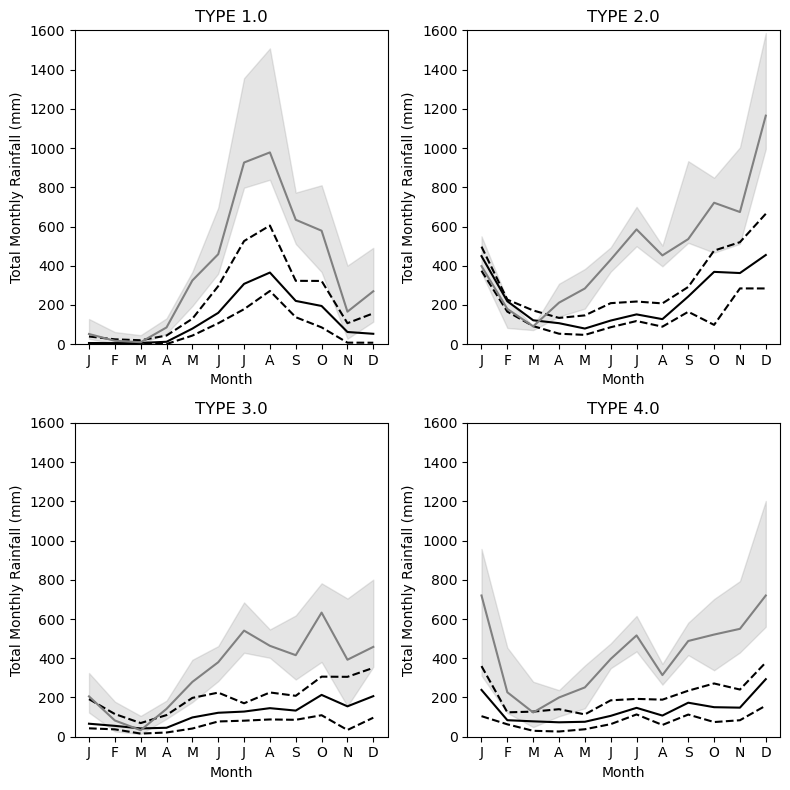

In [172]:
#Monthly statistics

wpf_imerg_monthly = wpf_imerg_daily_for_month.groupby(['station_id', 'year', 'month', 'CLIM_TYPE']).agg(
    wpf_monthly_Pr=('wpf_daily_Pr', 'sum'),
    imerg_monthly_Pr=('imerg_daily_Pr', 'sum')
).reset_index()

# Calculate the statistics (median, P25, P75) for WPF and IMERG data grouped by CLIM_TYPE and month
wpf_stats = wpf_imerg_monthly.groupby(['CLIM_TYPE', 'month'])['wpf_monthly_Pr'].agg(['median'])
wpf_stats['P25'] = wpf_imerg_monthly.groupby(['CLIM_TYPE', 'month'])['wpf_monthly_Pr'].quantile(0.25)
wpf_stats['P75'] = wpf_imerg_monthly.groupby(['CLIM_TYPE', 'month'])['wpf_monthly_Pr'].quantile(0.75)

imerg_stats = wpf_imerg_monthly.groupby(['CLIM_TYPE', 'month'])['imerg_monthly_Pr'].agg(['median'])
imerg_stats['P25'] = wpf_imerg_monthly.groupby(['CLIM_TYPE', 'month'])['imerg_monthly_Pr'].quantile(0.25)
imerg_stats['P75'] = wpf_imerg_monthly.groupby(['CLIM_TYPE', 'month'])['imerg_monthly_Pr'].quantile(0.75)

max_y = 1600

plt.figure(figsize=(8, 8))
positions = {1: 1, 2: 2, 3: 3, 4: 4}

for clim_type in wpf_stats.index.get_level_values(0).unique():
    plt.subplot(2, 2, positions[clim_type])
    
    wpf_subset = wpf_stats.loc[clim_type]
    imerg_subset = imerg_stats.loc[clim_type]
    
    # Plot WPF data
    plt.plot(wpf_subset.index, wpf_subset['median'], label=f'WPF TYPE {clim_type}', color='black')
    plt.plot(wpf_subset.index, wpf_subset['P25'], linestyle='--', color='black')
    plt.plot(wpf_subset.index, wpf_subset['P75'], linestyle='--', color='black')
    
    # Plot IMERG data
    plt.plot(imerg_subset.index, imerg_subset['median'], label=f'IMERG TYPE {clim_type}', color='gray')
    plt.fill_between(imerg_subset.index, imerg_subset['P25'], imerg_subset['P75'], color='gray', alpha=0.2)
    
    plt.xlabel('Month')
    plt.ylabel('Total Monthly Rainfall (mm)')
    plt.xticks(range(1, 13), ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    plt.title(f'TYPE {clim_type}')
    
    # Set consistent y-limits
    plt.ylim(0, max_y)
    
    # Add legend
    # plt.legend()

plt.tight_layout()
plt.show()

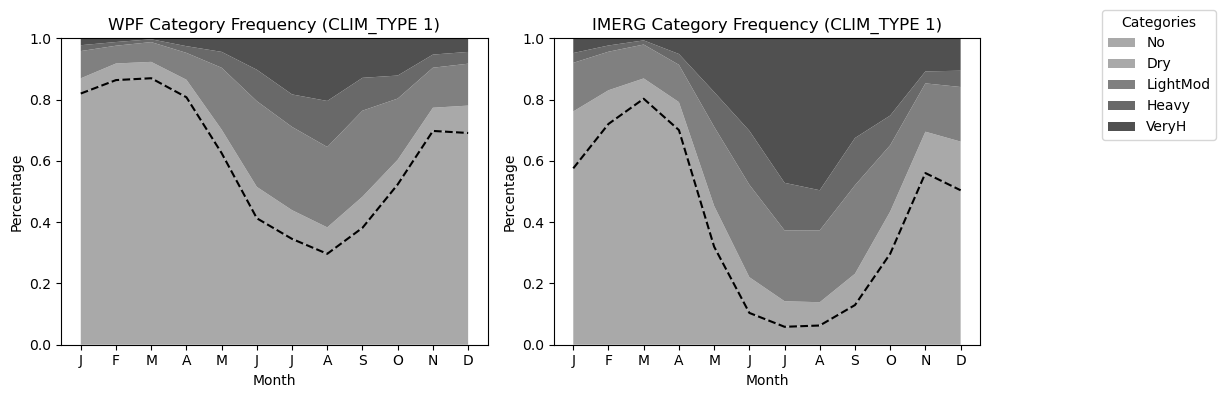

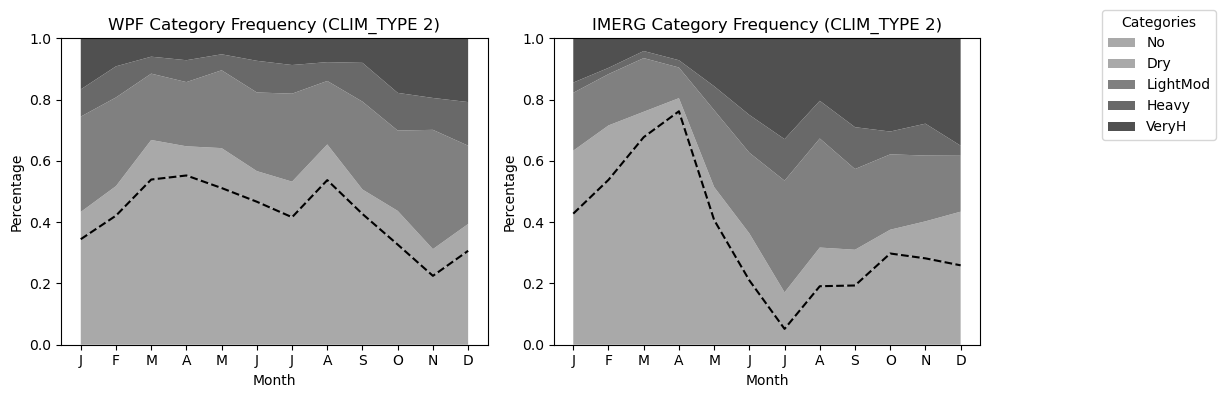

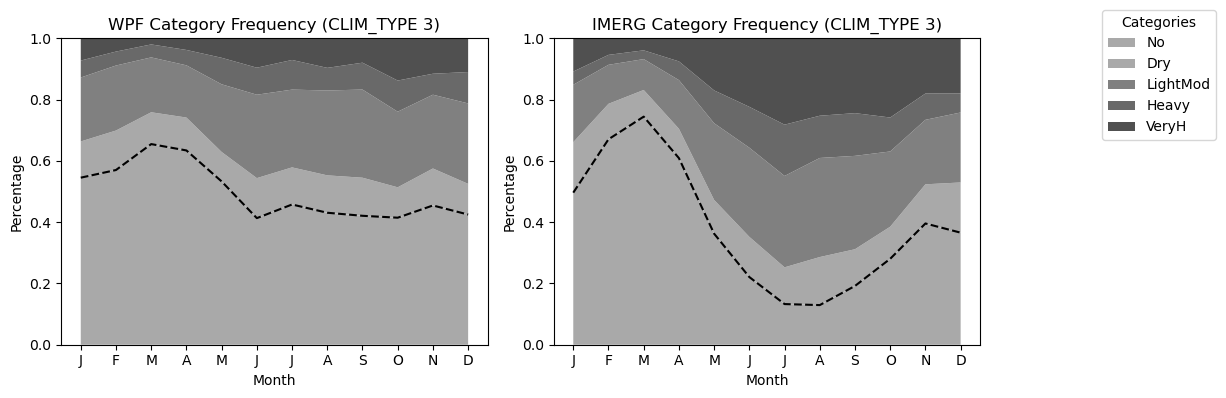

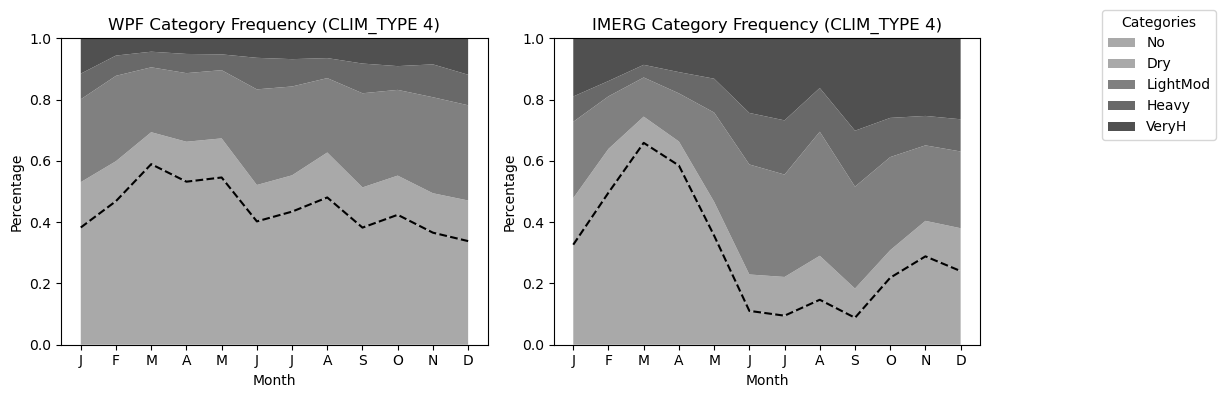

In [173]:
#Rainfall Category Frequency

months = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
category_order = ['No', 'Dry', 'LightMod', 'Heavy', 'VeryH']
colors = ['#A9A9A9', '#A9A9A9', '#808080', '#696969', '#505050']  # Gray shades, No and Dry share the same color

# Order of climate types
clim_type_order = [1, 2, 3, 4]

# Loop through each climate type in the specified order
for clim_type in clim_type_order:
    # Filter data by CLIM_TYPE
    filtered_data = wpf_imerg_daily_for_month[wpf_imerg_daily_for_month['CLIM_TYPE'] == clim_type]
    
    # Aggregate category counts by month across all years, separated by CLIM_TYPE
    wpf_categ_monthly = filtered_data.groupby('month')['wpf_categ'].value_counts(normalize=True).unstack(fill_value=0)
    imerg_categ_monthly = filtered_data.groupby('month')['imerg_categ'].value_counts(normalize=True).unstack(fill_value=0)
    
    # Reorder the columns in the DataFrames
    wpf_categ_monthly = wpf_categ_monthly[category_order]
    imerg_categ_monthly = imerg_categ_monthly[category_order]
    
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Plot the stacked area graph for wpf_categ on the left subplot
    axes[0].stackplot(wpf_categ_monthly.index, wpf_categ_monthly.T, labels=category_order, colors=colors)
    axes[0].plot(wpf_categ_monthly.index, wpf_categ_monthly['No'], linestyle='--', color='black')
    axes[0].set_ylim(0, 1)
    axes[0].set_xticks(range(1, 13))
    axes[0].set_xticklabels(months)
    axes[0].set_title(f'WPF Category Frequency (CLIM_TYPE {clim_type})')
    axes[0].set_ylabel('Percentage')
    axes[0].set_xlabel('Month')
    
    # Plot the stacked area graph for mswep_categ on the right subplot
    axes[1].stackplot(imerg_categ_monthly.index, imerg_categ_monthly.T, labels=category_order, colors=colors)
    axes[1].plot(imerg_categ_monthly.index, imerg_categ_monthly['No'], linestyle='--', color='black')
    axes[1].set_ylim(0, 1)
    axes[1].set_xticks(range(1, 13))
    axes[1].set_xticklabels(months)
    axes[1].set_title(f'IMERG Category Frequency (CLIM_TYPE {clim_type})')
    axes[1].set_ylabel('Percentage')
    axes[1].set_xlabel('Month')
    
    # Adjust layout and show legend only once
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Categories', bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

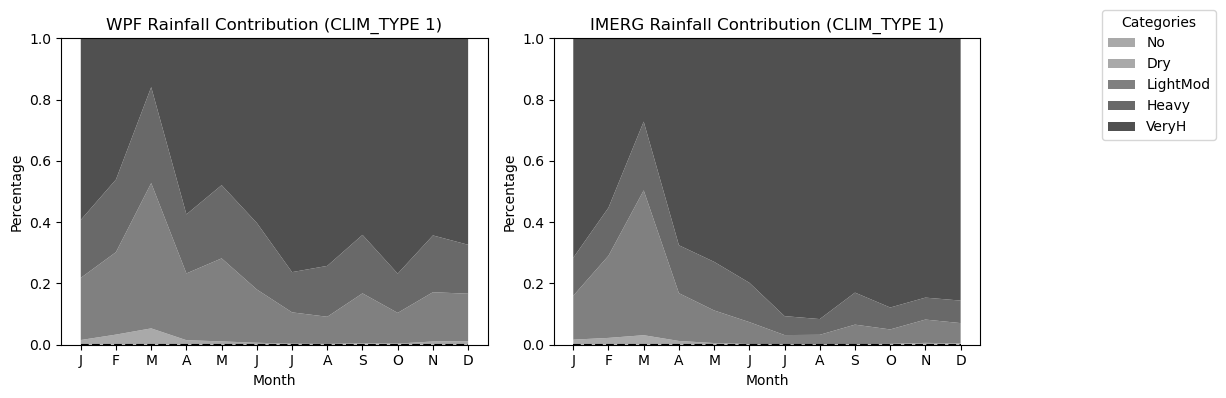

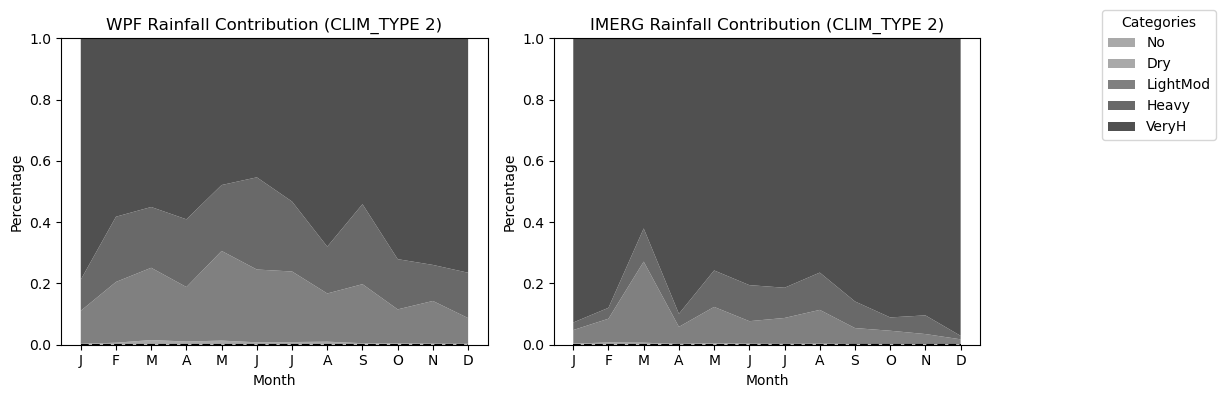

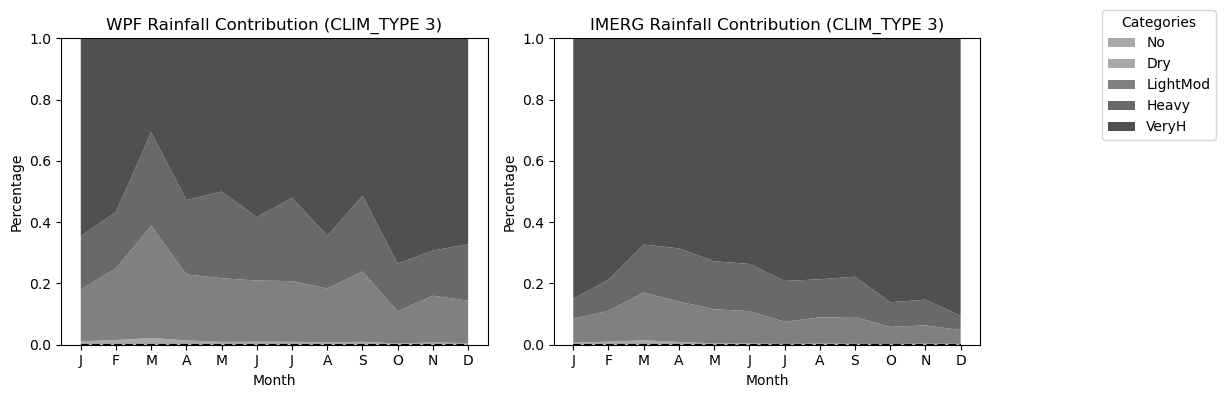

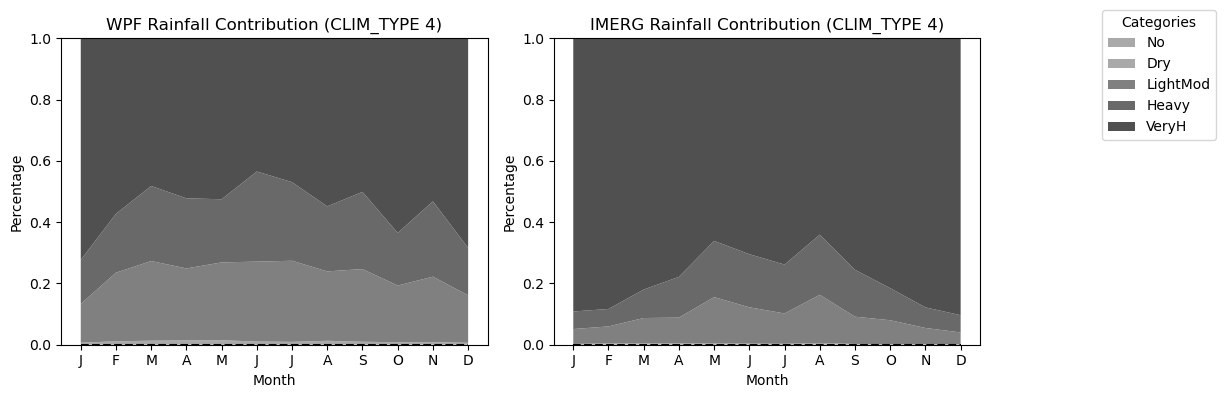

In [174]:
# Order of climate types
clim_type_order = [1, 2, 3, 4]

# Loop through each climate type in the specified order
for clim_type in clim_type_order:
    filtered_data = wpf_imerg_daily_for_month[wpf_imerg_daily_for_month['CLIM_TYPE'] == clim_type]
    wpf_rainfall = filtered_data.groupby(['year', 'month', 'wpf_categ'])['wpf_daily_Pr'].sum().unstack(fill_value=0)
    imerg_rainfall = filtered_data.groupby(['year', 'month', 'imerg_categ'])['imerg_daily_Pr'].sum().unstack(fill_value=0)

    wpf_rainfall_monthly = wpf_rainfall.groupby('month').sum()
    imerg_rainfall_monthly = imerg_rainfall.groupby('month').sum()

    wpf_rainfall_percent = wpf_rainfall_monthly.div(wpf_rainfall_monthly.sum(axis=1), axis=0)
    imerg_rainfall_percent = imerg_rainfall_monthly.div(imerg_rainfall_monthly.sum(axis=1), axis=0)

    wpf_rainfall_percent = wpf_rainfall_percent[category_order]
    imerg_rainfall_percent = imerg_rainfall_percent[category_order]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Plot the stacked area graph for wpf_categ on the left subplot
    axes[0].stackplot(wpf_rainfall_percent.index, wpf_rainfall_percent.T, labels=category_order, colors=colors)
    axes[0].plot(wpf_rainfall_percent.index, wpf_rainfall_percent['No'], linestyle='--', color='black')
    axes[0].set_ylim(0, 1)
    axes[0].set_xticks(range(1, 13))
    axes[0].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    axes[0].set_title(f'WPF Rainfall Contribution (CLIM_TYPE {clim_type})')
    axes[0].set_ylabel('Percentage')
    axes[0].set_xlabel('Month')

    # Plot the stacked area graph for mswep_categ on the right subplot
    axes[1].stackplot(imerg_rainfall_percent.index, imerg_rainfall_percent.T, labels=category_order, colors=colors)
    axes[1].plot(imerg_rainfall_percent.index, imerg_rainfall_percent['No'], linestyle='--', color='black')
    axes[1].set_ylim(0, 1)
    axes[1].set_xticks(range(1, 13))
    axes[1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    axes[1].set_title(f'IMERG Rainfall Contribution (CLIM_TYPE {clim_type})')
    axes[1].set_ylabel('Percentage')
    axes[1].set_xlabel('Month')

    # Adjust layout and show legend only once
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Categories', bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

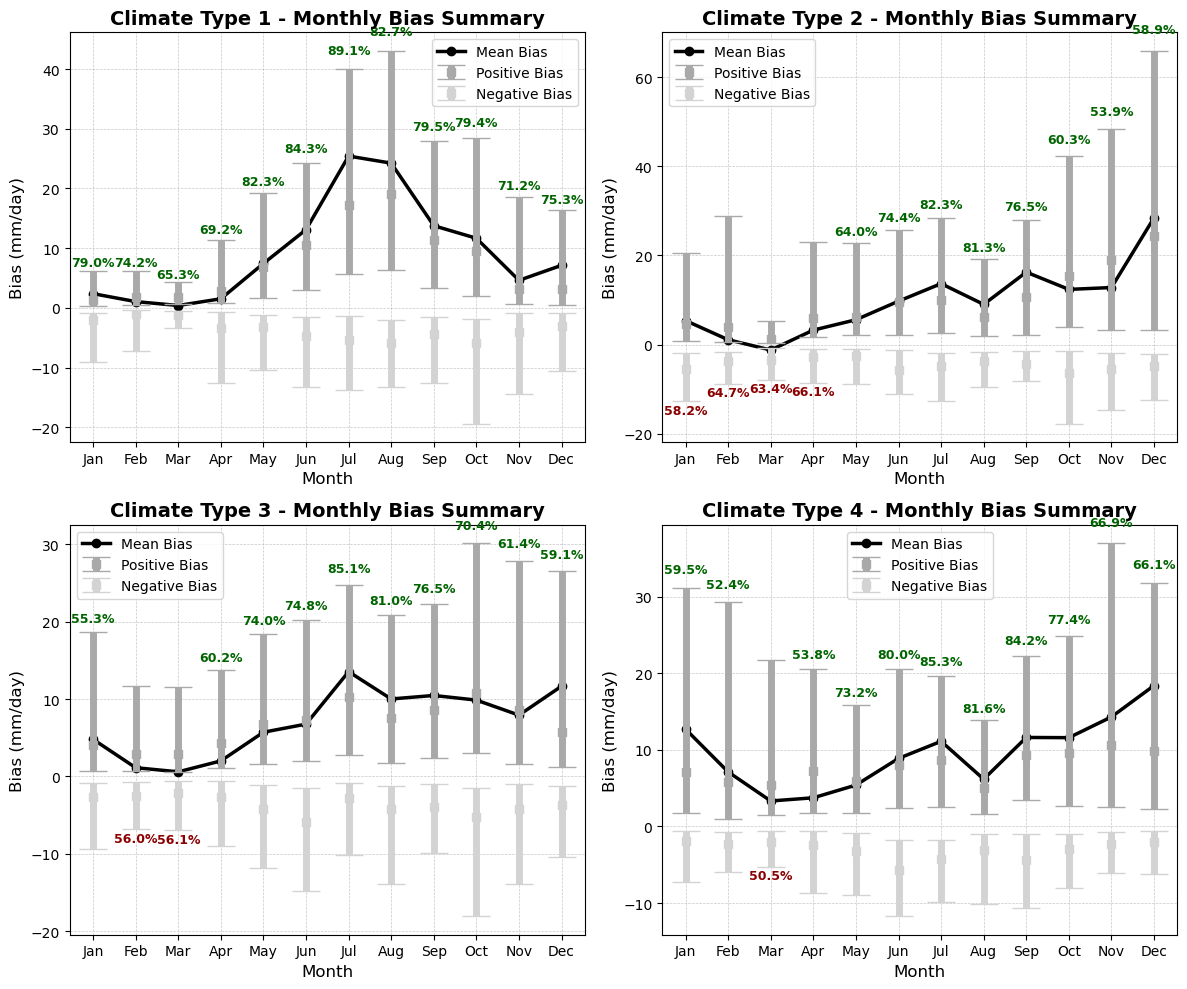

In [178]:
# Prepare the data
def prepare_bias_data(df, clim_type):
    # Filter the dataframe for the specific climate type
    data = df[df['CLIM_TYPE'] == clim_type].copy()

    # Handle infinite and NaN values
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna(subset=['Bias_imerg'])

    # Initialize lists to store statistics
    months = range(1, 13)
    mean_bias = []
    pos_median = []
    pos_p25 = []
    pos_p75 = []
    neg_median = []
    neg_p25 = []
    neg_p75 = []
    pos_freq = []
    neg_freq = []
    dominant_bias = []

    for month in months:
        month_data = data[data['month'] == month]
        biases = month_data['Bias_imerg']

        # Mean bias
        mean = biases.mean()
        mean_bias.append(mean)

        # Positive biases
        pos_biases = biases[biases > 0]
        pos_median.append(pos_biases.median())
        pos_p25.append(pos_biases.quantile(0.25))
        pos_p75.append(pos_biases.quantile(0.75))
        pos_count = pos_biases.count()

        # Negative biases
        neg_biases = biases[biases < 0]
        neg_median.append(neg_biases.median())
        neg_p25.append(neg_biases.quantile(0.25))
        neg_p75.append(neg_biases.quantile(0.75))
        neg_count = neg_biases.count()

        # Frequencies
        total_count = pos_count + neg_count
        if total_count == 0:
            pos_frequency = 0
            neg_frequency = 0
            dominant = 'No Data'
        else:
            pos_frequency = (pos_count / total_count) * 100
            neg_frequency = (neg_count / total_count) * 100
            dominant = 'Positive' if pos_frequency >= neg_frequency else 'Negative'

        pos_freq.append(pos_frequency)
        neg_freq.append(neg_frequency)
        dominant_bias.append(dominant)

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Month': months,
        'Mean_Bias': mean_bias,
        'Pos_Median': pos_median,
        'Pos_P25': pos_p25,
        'Pos_P75': pos_p75,
        'Neg_Median': neg_median,
        'Neg_P25': neg_p25,
        'Neg_P75': neg_p75,
        'Pos_Frequency': pos_freq,
        'Neg_Frequency': neg_freq,
        'Dominant_Bias': dominant_bias
    })

    return summary_df

# Plotting function
def plot_bias_summary(summary_df, ax, clim_type):
    months_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Plot mean bias
    ax.plot(summary_df['Month'], summary_df['Mean_Bias'], color='black', linewidth=2.5, label='Mean Bias', marker='o')

    # Plot positive bias bars
    ax.errorbar(
        summary_df['Month'],
        summary_df['Pos_Median'],
        yerr=[summary_df['Pos_Median'] - summary_df['Pos_P25'], summary_df['Pos_P75'] - summary_df['Pos_Median']],
        fmt='s',
        color='darkgray',
        ecolor='darkgray',
        elinewidth=5,
        capsize=10,
        label='Positive Bias'
    )

    # Plot negative bias bars
    ax.errorbar(
        summary_df['Month'],
        summary_df['Neg_Median'],
        yerr=[summary_df['Neg_Median'] - summary_df['Neg_P25'], summary_df['Neg_P75'] - summary_df['Neg_Median']],
        fmt='s',
        color='lightgray',
        ecolor='lightgray',
        elinewidth=5,
        capsize=10,
        label='Negative Bias'
    )

    # Add frequency annotations
    for idx, row in summary_df.iterrows():
        month = row['Month']
        if row['Dominant_Bias'] == 'Positive':
            ax.text(
                month,
                row['Pos_P75'] + 0.05 * abs(row['Pos_P75']),
                f"{row['Pos_Frequency']:.1f}%",
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold',
                color='darkgreen'
            )
        elif row['Dominant_Bias'] == 'Negative':
            ax.text(
                month,
                row['Neg_P25'] - 0.05 * abs(row['Neg_P25']),
                f"{row['Neg_Frequency']:.1f}%",
                ha='center',
                va='top',
                fontsize=9,
                fontweight='bold',
                color='darkred'
            )
        else:
            ax.text(
                month,
                0,
                "No Data",
                ha='center',
                va='center',
                fontsize=9,
                fontweight='bold',
                color='gray'
            )

    ax.set_xticks(summary_df['Month'])
    ax.set_xticklabels(months_labels)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Bias (mm/day)', fontsize=12)
    ax.set_title(f'Climate Type {clim_type} - Monthly Bias Summary', fontsize=14, fontweight='bold')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend()

# Main plotting routine for all climate types
def plot_all_climate_biases(df):
    climate_types = [1, 2, 3, 4]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    for clim_type, ax in zip(climate_types, axes.flatten()):
        summary_df = prepare_bias_data(df, clim_type)
        plot_bias_summary(summary_df, ax, clim_type)

    plt.tight_layout()
    plt.show()

plot_all_climate_biases(wpf_imerg_daily_for_month)

In [180]:
df_daily = wpf_imerg_daily
df_monthly = wpf_imerg_monthly

# Custom R^2 function based on the provided formula
def custom_r2(observed, predicted):
    # Calculate means
    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)
    
    # Calculate standard deviations
    std_observed = np.std(observed, ddof=1)  # ddof=1 for sample standard deviation
    std_predicted = np.std(predicted, ddof=1)
    
    # Calculate the numerator of the formula
    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    
    # Calculate the denominator
    denominator = (len(observed) - 1) * std_observed * std_predicted
    
    # Calculate R^2
    r2 = (numerator / denominator) ** 2
    
    return r2

# Function to remove NaN and inf values and compute statistics
def compute_stats(wpf_values, imerg_values):
    # Create a boolean mask to filter out NaN and inf values
    mask = ~np.isnan(wpf_values) & ~np.isnan(imerg_values) & \
           np.isfinite(wpf_values) & np.isfinite(imerg_values)
    
    # Filter the values based on the mask
    wpf_values_filtered = wpf_values[mask]
    imerg_values_filtered = imerg_values[mask]
    
    # Calculate statistics
    rmse = np.sqrt(mean_squared_error(wpf_values_filtered, imerg_values_filtered))
    mae = mean_absolute_error(wpf_values_filtered, imerg_values_filtered)
    r2 = custom_r2(wpf_values_filtered, imerg_values_filtered)
    ks_statistic, ks_p_value = stats.ks_2samp(wpf_values_filtered, imerg_values_filtered)
    
    return rmse, mae, r2, ks_statistic, ks_p_value

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Climate Type', 'Aggregation', 'RMSE', 'MAE', 'R2', 'KS_Statistic', 'KS_P_Value'])

# Iterate over each climate type
for clim_type in sorted(df_daily['CLIM_TYPE'].unique()):
    df_clim_daily = df_daily[df_daily['CLIM_TYPE'] == clim_type]
    df_clim_monthly = df_monthly[df_monthly['CLIM_TYPE'] == clim_type]

    # 1. Daily Statistics
    daily_stats = compute_stats(df_clim_daily['wpf_daily_Pr'], df_clim_daily['imerg_daily_Pr'])
    results_df = pd.concat([results_df, pd.DataFrame({
        'Climate Type': clim_type,
        'Aggregation': 'Daily',
        'RMSE': daily_stats[0],
        'MAE': daily_stats[1],
        'R2': daily_stats[2],
        'KS_Statistic': daily_stats[3],
        'KS_P_Value': daily_stats[4]
    }, index=[0])], ignore_index=True)

    # 2. Monthly Statistics
    monthly_stats = compute_stats(df_clim_monthly['wpf_monthly_Pr'], df_clim_monthly['imerg_monthly_Pr'])
    results_df = pd.concat([results_df, pd.DataFrame({
        'Climate Type': clim_type,
        'Aggregation': 'Monthly',
        'RMSE': monthly_stats[0],
        'MAE': monthly_stats[1],
        'R2': monthly_stats[2],
        'KS_Statistic': monthly_stats[3],
        'KS_P_Value': monthly_stats[4]
    }, index=[0])], ignore_index=True)

    # 3. Seasonal Statistics
    df_clim_monthly['season'] = np.where(df_clim_monthly['month'].isin([12, 1, 2]), 'DJF',
                                         np.where(df_clim_monthly['month'].isin([3, 4, 5]), 'MAM',
                                         np.where(df_clim_monthly['month'].isin([6, 7, 8]), 'JJA',
                                         'SON')))

    seasonal_df = df_clim_monthly.groupby(['station_id', 'year', 'season']).agg({
        'wpf_monthly_Pr': 'sum',
        'imerg_monthly_Pr': 'sum'
    }).reset_index()

    seasonal_stats = compute_stats(seasonal_df['wpf_monthly_Pr'], seasonal_df['imerg_monthly_Pr'])
    results_df = pd.concat([results_df, pd.DataFrame({
        'Climate Type': clim_type,
        'Aggregation': 'Seasonal',
        'RMSE': seasonal_stats[0],
        'MAE': seasonal_stats[1],
        'R2': seasonal_stats[2],
        'KS_Statistic': seasonal_stats[3],
        'KS_P_Value': seasonal_stats[4]
    }, index=[0])], ignore_index=True)

# The final results DataFrame
results_df

C:\Users\neris\AppData\Local\Temp\ipykernel_40900\1998503519.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({
C:\Users\neris\AppData\Local\Temp\ipykernel_40900\1998503519.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clim_monthly['season'] = np.where(df_clim_monthly['month'].isin([12, 1, 2]), 'DJF',
C:\Users\neris\AppData\Local\Temp\ipykernel_40900\1998503519.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,Climate Type,Aggregation,RMSE,MAE,R2,KS_Statistic,KS_P_Value
0,1.0,Daily,29.338540,12.128268,0.399942,0.209686,0.000000e+00
1,1.0,Monthly,461.937546,316.056183,0.488583,0.359677,5.061901e-36
2,1.0,Seasonal,1176.875819,847.839004,0.478681,0.374449,1.473477e-14
3,2.0,Daily,41.213520,16.532089,0.228472,0.111780,2.145038e-19
4,2.0,Monthly,469.207351,355.385650,0.140965,0.462264,1.353974e-10
5,2.0,Seasonal,1109.739795,889.208470,0.227148,0.550000,6.608193e-06
6,3.0,Daily,28.104703,11.665378,0.215929,0.123692,2.675764e-127
7,3.0,Monthly,345.972348,267.514759,0.129825,0.421667,3.397544e-48
8,3.0,Seasonal,890.206683,727.379122,0.061175,0.519048,3.593216e-26
9,4.0,Daily,30.743863,12.839043,0.332540,0.179498,1.273757e-208
